In [25]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px


# Create the Snowflake connection hook once
snowhook = SnowflakeHook(warehouse="TEAM_DATA_ANALYTICS")

# Function for queries
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    df = snowhook.query_snowflake(query, method='pandas')

    # format Decimal -> float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)
    return df


2025-09-10 15:56:44,947 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-10 15:56:44,948 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


## 0. DATA Prep

#### Applicants by CBSA

In [26]:
df_apps_by_cbsa_raw = load_query('data/sql/monthly_apps_by_cbsa.sql')
df_apps_by_cbsa_raw['month'] = pd.to_datetime(df_apps_by_cbsa_raw['month'])
df_apps_by_cbsa = df_apps_by_cbsa_raw[(df_apps_by_cbsa_raw['cbsa'] != '99999') & (~df_apps_by_cbsa_raw['cbsa'].isna()) & (~df_apps_by_cbsa_raw['msa'].isna())]
df_apps_by_cbsa.head()

2025-09-10 15:56:45,468 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-10 15:56:45,469 - utils.snowflake_connection - INFO - Executing query (pandas)


,cbsa,month,apps,apps_18_to_19,apps_18_to_24,apps_25_to_44,apps_45_to_64,apps_65_above,apps_18plus,msa,age18plus_tot,age1824_tot,apps_18plus_share_of_population,apps_18to24_share_of_population
21,10740,2025-03-01,1832,66,305,456,115,11,1832,"Albuquerque, NM",740683.0,81091.0,0.002473,0.003761
22,10740,2023-07-01,1652,4,188,265,104,7,1652,"Albuquerque, NM",740683.0,81091.0,0.002230,0.002318
23,10740,2023-01-01,1715,3,313,555,126,9,1715,"Albuquerque, NM",740683.0,81091.0,0.002315,0.003860
24,10740,2024-06-01,1799,35,208,352,94,9,1799,"Albuquerque, NM",740683.0,81091.0,0.002429,0.002565
25,10740,2023-05-01,1583,10,113,177,78,7,1583,"Albuquerque, NM",740683.0,81091.0,0.002137,0.001393


#### Demand by CBSA

In [27]:
df_demand_by_msa = load_query('data/sql/monthly_demand_by_cbsa.sql')
df_demand_by_msa['month'] = pd.to_datetime(df_demand_by_msa['month'])
df_demand_by_msa = df_demand_by_msa[(df_demand_by_msa['cbsa'] != '99999') & (~df_demand_by_msa['cbsa'].isna())]
df_demand_by_msa

2025-09-10 15:56:45,997 - utils.snowflake_connection - INFO - Executing query (pandas)


,month,cbsa,num_delivs
0,2023-01-01,21780,100145
2,2024-07-01,38060,2968585
3,2024-02-01,47900,3922392
4,2023-08-01,41860,3924914
5,2023-04-01,42220,323636
...,...,...,...
28503,2023-09-01,20580,13769
28504,2023-04-01,46980,14175
28505,2023-12-01,31220,8157
28506,2023-02-01,27940,4997


#### Mega Dataset

In [28]:
df_ur_by_msa = pd.read_csv('data/external/df_ur_by_msa.csv')
df_ur_by_msa['month'] = pd.to_datetime(df_ur_by_msa['month'])
df_ur_by_msa = df_ur_by_msa[['month','msa','ur','civilian_labor_force', 'employment', 'unemployment']]
# df_ur_by_msa = df_ur_by_msa[['month','msa','ur','civilian_labor_force', 'employment', 'unemployment']]
# df_ur_by_msa

df_cpi_by_msa = pd.read_csv('data/external/df_monthly_cpi_by_msa.csv')
df_cpi_by_msa['month'] = pd.to_datetime(df_cpi_by_msa['month'])
df_cpi_by_msa['cbsa'] = df_cpi_by_msa['cbsa'].astype(str)
df_cpi_by_msa = df_cpi_by_msa[['month','cbsa','cpi_value']]


df_min_wage_by_msa = pd.read_csv('data/external/df_monthly_min_wage_by_msa.csv')
df_min_wage_by_msa['month'] = pd.to_datetime(df_min_wage_by_msa['month'])
df_min_wage_by_msa['cbsa'] = df_min_wage_by_msa['cbsa'].astype(str)
df_min_wage_by_msa = df_min_wage_by_msa[['month','cbsa','min_wage']]

In [29]:
df_mega_dataset = df_ur_by_msa.merge(df_apps_by_cbsa, left_on=['month','msa'], right_on=['month','msa'], how='left').reset_index(drop=True)
df_mega_dataset = df_mega_dataset.merge(df_cpi_by_msa, left_on=['month','cbsa'], right_on=['month','cbsa'], how='left').reset_index(drop=True)
df_mega_dataset = df_mega_dataset.merge(df_min_wage_by_msa, left_on=['month','cbsa'], right_on=['month','cbsa'], how='left').reset_index(drop=True)
df_mega_dataset = df_mega_dataset.merge(df_demand_by_msa, left_on=['month','cbsa'], right_on=['month','cbsa'], how='left').reset_index(drop=True)
df_mega_dataset

,month,msa,ur,civilian_labor_force,employment,unemployment,cbsa,apps,apps_18_to_19,apps_18_to_24,...,apps_45_to_64,apps_65_above,apps_18plus,age18plus_tot,age1824_tot,apps_18plus_share_of_population,apps_18to24_share_of_population,cpi_value,min_wage,num_delivs
0,2023-01-01,"Anniston-Oxford, AL",2.3,49175,48051,1124,11500,360.0,5.0,64.0,...,24.0,3.0,360.0,91522.0,12627.0,0.003933,0.005069,299.520571,7.25,36380.0
1,2023-01-01,"Auburn-Opelika, AL",2.2,92671,90660,2011,12220,641.0,2.0,161.0,...,28.0,1.0,641.0,164729.0,34370.0,0.003891,0.004684,299.520571,7.25,84180.0
2,2023-01-01,"Birmingham, AL",2.1,558178,546516,11662,13820,2677.0,21.0,452.0,...,203.0,25.0,2677.0,923519.0,104761.0,0.002899,0.004315,299.520571,7.25,508823.0
3,2023-01-01,"Daphne-Fairhope-Foley, AL",1.9,111910,109774,2136,19300,506.0,2.0,80.0,...,60.0,12.0,506.0,207358.0,18719.0,0.002440,0.004274,299.520571,7.25,60422.0
4,2023-01-01,"Decatur, AL",1.8,73279,71924,1355,19460,458.0,5.0,70.0,...,40.0,3.0,458.0,123151.0,12848.0,0.003719,0.005448,299.520571,7.25,42266.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17181,2025-07-01,"Racine-Mount Pleasant, WI",3.7,99966,96290,3676,39540,648.0,60.0,128.0,...,48.0,5.0,648.0,154371.0,16151.0,0.004198,0.007925,323.213867,7.25,148236.0
17182,2025-07-01,"Sheboygan, WI",2.7,63470,61767,1703,43100,203.0,12.0,35.0,...,9.0,3.0,203.0,93577.0,9912.0,0.002169,0.003531,323.213867,7.25,49041.0
17183,2025-07-01,"Wausau, WI",2.7,74510,72518,1992,48140,275.0,37.0,77.0,...,20.0,1.0,275.0,108381.0,10235.0,0.002537,0.007523,323.213867,7.25,69535.0
17184,2025-07-01,"Casper, WY",3.3,41498,40135,1363,16220,166.0,10.0,16.0,...,3.0,0.0,166.0,62029.0,6396.0,0.002676,0.002502,324.130395,5.15,64492.0


## 1. Analysis

Run a regression analysis:

YoY% in Applicants ~ YoY% in Unemployment Rate + YoY% in CPI + YoY% in Min Wage + Population (abs) + MSA Fixed Effects

In [30]:
df_mega_dataset_clean = df_mega_dataset[['month','cbsa','msa','apps_18plus','ur','cpi_value','min_wage','age18plus_tot','num_delivs','apps_18_to_24']]
df_mega_dataset_clean = df_mega_dataset_clean.groupby(['month','cbsa','msa','apps_18plus', 'apps_18_to_24', 'ur','age18plus_tot','num_delivs']).agg({'cpi_value':max,'min_wage':max}).reset_index(drop = False)
df_mega_dataset_clean

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_11631/2745696105.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_mega_dataset_clean = df_mega_dataset_clean.groupby(['month','cbsa','msa','apps_18plus', 'apps_18_to_24', 'ur','age18plus_tot','num_delivs']).agg({'cpi_value':max,'min_wage':max}).reset_index(drop = False)
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_11631/2745696105.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_mega_dataset_clean = df_mega_dataset_clean.groupby(['month','cbsa','msa','apps_18plus', 'apps_18_to_24', 'ur','age18plus_tot','num_delivs']).agg({'cpi_value':m

,month,cbsa,msa,apps_18plus,apps_18_to_24,ur,age18plus_tot,num_delivs,cpi_value,min_wage
0,2023-01-01,10180,"Abilene, TX",356.0,59.0,3.7,141789.0,59897.0,299.919457,7.25
1,2023-01-01,10420,"Akron, OH",1956.0,395.0,3.7,563683.0,561302.0,300.286892,10.10
2,2023-01-01,10500,"Albany, GA",458.0,57.0,4.0,111114.0,53053.0,299.195671,5.15
3,2023-01-01,10540,"Albany, OR",374.0,76.0,4.2,103982.0,60038.0,298.082269,14.20
4,2023-01-01,10580,"Albany-Schenectady-Troy, NY",1462.0,273.0,2.9,742556.0,315222.0,318.151000,14.20
...,...,...,...,...,...,...,...,...,...,...
11377,2025-07-01,49420,"Yakima, WA",451.0,34.0,5.8,185649.0,72890.0,322.491819,16.28
11378,2025-07-01,49620,"York-Hanover, PA",1069.0,252.0,3.8,369446.0,319233.0,322.991039,7.25
11379,2025-07-01,49660,"Youngstown-Warren, OH",1131.0,273.0,5.9,339748.0,388642.0,323.067356,10.45
11380,2025-07-01,49700,"Yuba City, CA",419.0,6.0,7.9,138181.0,117138.0,322.842534,16.00


In [31]:
len(df_mega_dataset_clean['month'].unique()) * len(df_mega_dataset_clean['msa'].unique())

11470

In [32]:
# Sort before calculating YoY changes
df = df_mega_dataset_clean.sort_values(['cbsa', 'month'])

df['delivs_density'] = df['num_delivs'] / df['age18plus_tot']
# Calculate YoY% change for each CBSA
for col in ['apps_18plus', 'cpi_value', 'min_wage', 'num_delivs', 'apps_18_to_24', 'delivs_density']:
    df[f'{col}_yoy'] = df.groupby('cbsa')[col].pct_change(periods=12) 

df['ur_yoy'] = df.groupby('cbsa')['ur'].pct_change(periods=12)

df_model_prep = df.dropna(subset=['apps_18plus_yoy', 'ur_yoy', 'cpi_value_yoy', 'min_wage_yoy', 'num_delivs_yoy', 'apps_18_to_24_yoy', 'delivs_density_yoy'])

# Optional: Rename for convenience
df_model_prep = df_model_prep.rename(columns={
    'apps_18plus_yoy': 'yoy_apps',
    'apps_18_to_24_yoy': 'yoy_apps_18_to_24',
    'ur_yoy': 'yoy_ur',
    'cpi_value_yoy': 'yoy_cpi',
    'min_wage_yoy': 'yoy_minwage',
    'num_delivs_yoy': 'yoy_delivs',
    'delivs_density_yoy': 'yoy_delivs_density',
})


# drop the regulated markets: d.c., seattle, ny, california
cali_msa = df_model_prep[df_model_prep['msa'].str.contains('CA')]['cbsa'].unique().tolist()
ny_msa = ['35620'] # New York-Newark-Jersey City, NY-NJ, df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('NY')]
seattle_msa = ['42660'] # Seattle-Tacoma-Bellevue, WA, df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('Seattle')]
dc_msa = ['47900', '12580'] # Washington-Arlington-Alexandria, DC-VA-MD-WV, df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('DC')]
regulatory_markets_msa = cali_msa + ny_msa + seattle_msa + dc_msa
df_model_prep = df_model_prep[~df_model_prep['cbsa'].isin(regulatory_markets_msa)].reset_index(drop=True)

# drop extreme outliers
df_model_prep = df_model_prep[(df_model_prep['yoy_apps'] <= 4) & (df_model_prep['yoy_apps'] >= -4) & (df_model_prep['yoy_ur'] <= 2) & (df_model_prep['yoy_ur'] >= -2)]

In [33]:
# top_100_MSAs_population = df_model_prep[df_model_prep['month'] == '2024-08-01'].sort_values(by='age18plus_tot', ascending=False).head(50)
# df_model_prep = df_model_prep[~df_model_prep['cbsa'].isin(top_100_MSAs_population['cbsa'])]

In [34]:
"""
normalize the metrics using z-score method
(metric - mean) / std
"""

# drop extreme outliers

df_clean = df_model_prep.copy()

for col in ['yoy_apps', 'yoy_ur']:
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # df_clean[col] = scaler.fit_transform(df_clean[[col]])
    # df_clean[col] = (df_clean[col] - df_clean[col].min()) / (df_clean[col].max() - df_clean[col].min())
    df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()

for col in ['yoy_cpi', 'yoy_minwage', 'yoy_delivs_density']:
    df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
    # df_clean[col] = (df_clean[col] - df_clean[col].min()) / (df_clean[col].max() - df_clean[col].min())

for col in ['age18plus_tot', 'num_delivs']:
    df_clean[f'{col}_log'] = np.log(df_clean[col])
# # turn absolute value into 0-1 scale
for col in ['age18plus_tot_log', 'num_delivs_log', 'min_wage', 'cpi_value','cpi_value', 'apps_18_to_24','apps_18plus','ur']:
    df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
    # df_clean[col] = (df_clean[col] - df_clean[col].min()) / (df_clean[col].max() - df_clean[col].min())

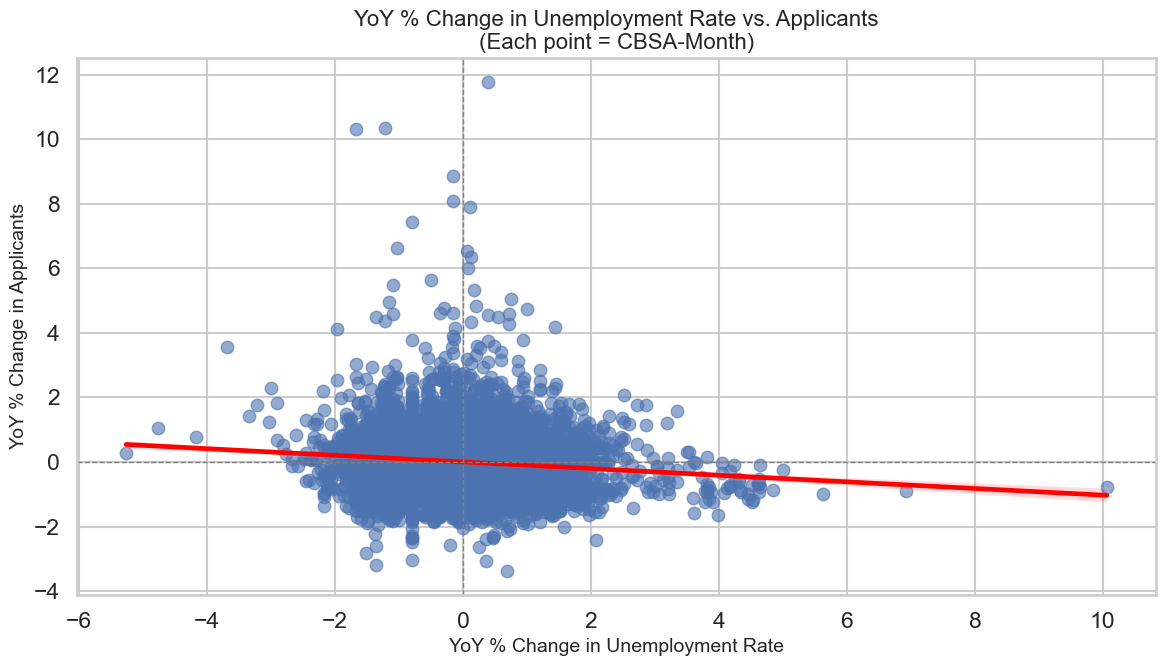

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
sns.set(style="whitegrid", context="talk")

# Create the plot with regression line
plt.figure(figsize=(12, 7))
sns.regplot(
    data=df_clean,
    x='yoy_ur',
    y='yoy_apps',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'},
    ci=95  # Confidence interval for the regression line
)

# Add titles and labels
plt.title("YoY % Change in Unemployment Rate vs. Applicants\n(Each point = CBSA-Month)", fontsize=16)
plt.xlabel("YoY % Change in Unemployment Rate", fontsize=14)
plt.ylabel("YoY % Change in Applicants", fontsize=14)

# Add zero lines for visual reference
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_clean[['age18plus_tot_log', 'min_wage', 'cpi_value', 'delivs_density']]  # or full model matrix
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


            Variable       VIF
0  age18plus_tot_log  1.005241
1           min_wage  1.058887
2          cpi_value  1.053968
3     delivs_density  1.006349


In [37]:
df_clean[['age18plus_tot_log', 'delivs_density']].corr()

,age18plus_tot_log,delivs_density
age18plus_tot_log,1.000000,0.111633
delivs_density,0.111633,1.000000


In [38]:
import statsmodels.formula.api as smf

df_clean['month_fe'] = df_clean['month'].dt.month
df_clean['year_fe'] = df_clean['month'].dt.year


df_clean['cbsa'] = df_clean['cbsa'].astype('category')
# Define formula with fixed effects (MSA dummies)
formula = (
    "yoy_apps ~ yoy_ur + yoy_cpi + yoy_minwage + yoy_delivs_density"
    # "min_wage + cpi_value  + delivs_density +"
    "+ C(cbsa) + C(month_fe) + C(year_fe)"
)

# Run the regression with robust standard errors (White’s)
model = smf.ols(formula=formula, data=df_clean).fit(cov_type='HC3')

print(model.summary())
# import statsmodels.api as sm
# model_glm = smf.glm(formula=formula, data=df_clean,
#                     family=sm.families.Gaussian()).fit(cov_type='HC3')

# print(model_glm.summary())

                            OLS Regression Results                            
Dep. Variable:               yoy_apps   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     16.41
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:56:48   Log-Likelihood:                -7169.5
No. Observations:                6420   AIC:                         1.505e+04
Df Residuals:                    6066   BIC:                         1.744e+04
Df Model:                         353                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.6547      0

In [39]:
import pandas as pd

# Extract regression results table from the model summary
summary_table = model.summary2().tables[1]

# Select only the metrics you're interested in
metrics = ['yoy_ur', 'yoy_cpi', 'yoy_minwage', 'yoy_delivs_density']
summary_df = summary_table.loc[metrics, ['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']]

# Rename columns for clarity
summary_df.columns = ['coef', 'std_err', 'z', 'p_value', 'ci_lower', 'ci_upper']

# Reset index to make 'metric' a column
summary_df.index.name = 'metric'
summary_df.reset_index(inplace=True)

# Print the result
summary_df


,metric,coef,std_err,z,p_value,ci_lower,ci_upper
0,yoy_ur,0.025683,0.012314,2.085690,3.700671e-02,0.001548,0.049817
1,yoy_cpi,-0.013120,0.015160,-0.865489,3.867707e-01,-0.042833,0.016592
2,yoy_minwage,-0.045954,0.019714,-2.331045,1.975100e-02,-0.084592,-0.007315
3,yoy_delivs_density,0.079087,0.016137,4.901020,9.534048e-07,0.047459,0.110715


In [40]:
# Step 1: Extract regression coefficients
summary_df = model.summary2().tables[1]
metrics = ['yoy_ur', 'yoy_cpi', 'yoy_minwage', 'yoy_delivs_density']

# Filter for target metrics
reg_results = summary_df.loc[metrics, ['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']]
reg_results.columns = ['coef', 'std_err', 'z', 'p_value', 'ci_lower', 'ci_upper']
reg_results.index.name = 'metric'
reg_results.reset_index(inplace=True)

level_mapping = {
    'yoy_ur': 'ur',
    'yoy_cpi': 'cpi_value',
    'yoy_minwage': 'min_wage',
    'yoy_delivs_density': 'delivs_density',
    # 'yoy_apps': 'apps_18plus'
}

metric_means = pd.Series({metric: df_model_prep[metric].mean() for metric in metrics}, name='metric_mean')
metric_std = pd.Series({metric: df_model_prep[metric].std() for metric in metrics}, name='metric_std')
level_means = pd.Series({metric: df_model_prep[col].mean() for metric, col in level_mapping.items()}, name='level_mean')
level_std = pd.Series({metric: df_model_prep[col].std() for metric, col in level_mapping.items()}, name='level_std')
# Step 4: Merge all together
reg_results['metric_mean'] = reg_results['metric'].map(metric_means)
reg_results['metric_std']  = reg_results['metric'].map(metric_std)
reg_results['level_mean'] = reg_results['metric'].map(level_means)
reg_results['level_std'] = reg_results['metric'].map(level_std)

yoy_apps_mean = df_model_prep['yoy_apps'].mean()
yoy_apps_std = df_model_prep['yoy_apps'].std()

reg_results['yoy_apps_mean'] = yoy_apps_mean
reg_results['yoy_apps_std'] = yoy_apps_std

In [41]:
reg_results = reg_results.round(6)
reg_results

,metric,coef,std_err,z,p_value,ci_lower,ci_upper,metric_mean,metric_std,level_mean,level_std,yoy_apps_mean,yoy_apps_std
0,yoy_ur,0.025683,0.012314,2.085690,0.037007,0.001548,0.049817,0.095390,0.120682,3.897477,1.007526,0.15898,0.284172
1,yoy_cpi,-0.013120,0.015160,-0.865489,0.386771,-0.042833,0.016592,0.028663,0.004238,317.054534,5.676960,0.15898,0.284172
2,yoy_minwage,-0.045954,0.019714,-2.331045,0.019751,-0.084592,-0.007315,0.012328,0.028486,9.816893,3.210128,0.15898,0.284172
3,yoy_delivs_density,0.079087,0.016137,4.901020,0.000001,0.047459,0.110715,0.210913,0.078571,0.728756,0.232310,0.15898,0.284172


## Validation

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_clean[['yoy_ur', 'yoy_cpi', 'yoy_minwage', 'yoy_delivs_density']]
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


              feature       VIF
0              yoy_ur  1.020670
1             yoy_cpi  1.041606
2         yoy_minwage  1.043431
3  yoy_delivs_density  1.029946


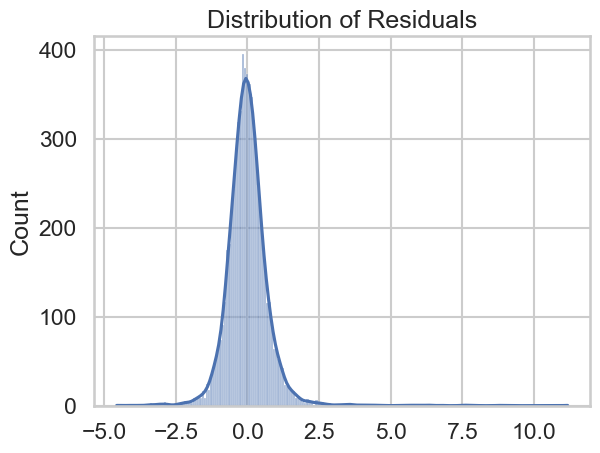

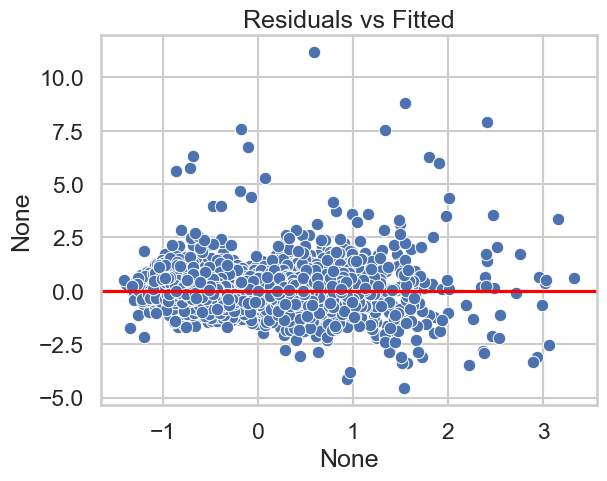

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(0, color='red')
plt.title("Residuals vs Fitted")
plt.show()


In [44]:
import numpy as np

condition_number = np.linalg.cond(X.values)
print(f"Condition number: {condition_number:.2e}")


Condition number: 1.25e+00


## Visualization & Translation

### Visuals

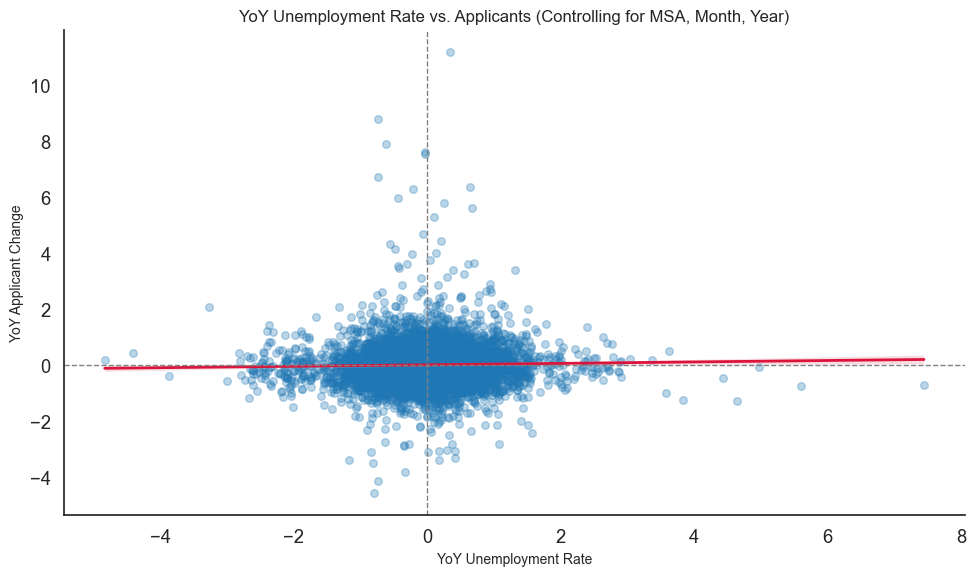

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Residualize yoy_apps ~ FE
resid_y = smf.ols("yoy_apps ~ yoy_cpi + yoy_minwage + yoy_delivs_density +C(cbsa) + C(month_fe) + C(year_fe)", data=df_clean).fit().resid

# 2. Residualize yoy_ur ~ FE
resid_x = smf.ols("yoy_ur ~ yoy_cpi + yoy_minwage + yoy_delivs_density + C(cbsa) + C(month_fe) + C(year_fe)", data=df_clean).fit().resid

# 3. Plot residuals against each other
plt.figure(figsize=(10, 6))
sns.set(style="white", font_scale=1.2)
sns.regplot(
    x=resid_x, 
    y=resid_y, 
    scatter_kws={'alpha': 0.3, 'color': '#1f77b4', 's': 30},
    line_kws={'color': 'crimson', 'linewidth': 2},
    ci=95
)

# Styling
plt.title("YoY Unemployment Rate vs. Applicants (Controlling for MSA, Month, Year)", fontsize=12)
plt.xlabel("YoY Unemployment Rate", fontsize=10)
plt.ylabel("YoY Applicant Change", fontsize=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
sns.despine()
plt.tight_layout()
plt.show()


### Translation

In [46]:
yoy_ur_mean = df_model_prep['yoy_ur'].mean()
yoy_ur_std = df_model_prep['yoy_ur'].std()

yoy_apps_mean = df_model_prep['yoy_apps'].mean()
yoy_apps_std = df_model_prep['yoy_apps'].std()

print(yoy_ur_mean, yoy_ur_std)
print(yoy_apps_mean, yoy_apps_std)


0.09539035035625948 0.1206823231707142
0.15898045745763906 0.28417243585194096


In [47]:
# model output: UR -> Apps
# ur_coef = 0.0271 
ur_coef = 0.025683
# x variable: increases by 1 std
yoy_ur_pred = yoy_ur_std + yoy_ur_mean
yoy_ur_inc = yoy_ur_pred - yoy_ur_mean

# y variable: increases by ur_coef * yoy_apps_std
yoy_apps_pred = ur_coef * yoy_apps_std + yoy_apps_mean
yoy_apps_inc = yoy_apps_pred - yoy_apps_mean

yoy_ur_inc = yoy_ur_pred - yoy_ur_mean

print(yoy_ur_inc , yoy_apps_inc)

ur_mean = df_model_prep[df_model_prep['month'].dt.year == 2024]['ur'].mean()
# ur_mean_weighted = np.average(df_model_prep['ur'], weights=df_model_prep['age18plus_tot'])
yoy_apps_inc_rel = yoy_apps_inc / (ur_mean * yoy_ur_inc) * 100
yoy_apps_inc_rel = yoy_apps_inc_rel.round(2) 

print("1pp UR y/y increase abs. ->" + f"{yoy_apps_inc_rel}" +"% apps y/y increase")

0.1206823231707142 0.007298400669985411
1pp UR y/y increase abs. ->1.57% apps y/y increase
